In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import ipywidgets as wdg
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern, ConstantKernel, DotProduct
from sklearn.gaussian_process import GaussianProcessRegressor
import scipy.stats as ss
import ipywidgets as wdg

# Gaussian Process Regression

## Reminder of Linear Regression (LR)

In linear regression, we are given $x_i \in \mathbb{R}^m$, $y_i \in \mathbb{R}$, $i=1, \ldots, N$, and we want to fit a linear hypothesis $f=f_w:\mathbb{R}^m \to \mathbb{R}$, $x \mapsto x^{\top} w$, $w \in \mathbb{R}^m$ to that data. We assume that
\begin{align*}
    y_i = f_w(x_i) + \varepsilon_i,
\end{align*}
where $\varepsilon_i$ are realizations of an iid random variable $\varepsilon$ with zero mean called *noise*. The problem of finding $w$ is typically achieved by solving the least squares problem
\begin{align*}
    \hat w = \operatorname{argmin}_{w}{\sum_{i=1}^{N}{(f_{w}(x_i)-y_i)^2}}.
\end{align*}
If we collect all the inputs in the *design matrix* (written as column matrix)
\begin{align*}
    X := \begin{pmatrix}
        x_1 &
        \ldots &
        x_N 
    \end{pmatrix} \in \mathbb{R}^{m \times N}
\end{align*}
the solution $\hat w $ to the least squares problem is given by the *normal equation*
\begin{align*}
     \hat w = (X X^{\top})^{-1} X y \in \mathbb{R}^{m}
\end{align*}
under the assumption that $XX^{\top} \in \mathbb{R}^{m \times m}$ is invertible. For practical applications with $N \gg m$, this is typically the case.

We can then make predictions on new data $x_* \in \mathbb{R}^m$ via $f_{\hat w}(x_*) = x_*^{\top} w \in \mathbb{R}$. In case of multiple predictions, we can collect them in a matrix $X_* \in \mathbb{R}^{m \times l}$ resulting in
\begin{align*}
    F_* := f_{\hat w}(X_*) := X_*^{\top} \hat w = X_*^{\top} (X X^{\top})^{-1} X y \in \mathbb{R}^l
\end{align*}

## Feature Extraction
In many cases, the design matrix is not given and needs to be assembled. In that case, the data is in some space $x_i \in \mathbb{R}^k$ and we assume that there is a map $\phi:\mathbb{R}^{k} \to \mathbb{R}^m$. The resulting design matrix is then
\begin{align*}
    X_{\Phi} := \Phi(X) := \begin{pmatrix}
        \phi(x_1) \\
        \ldots \\
        \phi(x_N) \\
    \end{pmatrix} \in \mathbb{R}^{m \times N}
\end{align*}
A standard example is polynomial regression, where $k=1$, i.e. the original data $x_i \in \mathbb{R}$ is scalar, and 
\begin{align*}
    \phi(x) := \begin{pmatrix}
        1 & x & x^2 \ldots & x^d
    \end{pmatrix}^{\top}
\end{align*}.

# Derivation of GPR as a Bayesian View of Linear Regression
Even the standard linear regression has a probabilistic component, namely the noise $\varepsilon$. We now take a completely probabilistic view of it and make the following

**Assumptions**: Let
* $(\Omega, \mathcal{F}, \mathbb{P})$ be a probability space
* $x_i$ be $\mathbb{R}^m$-valued iid random variables
* $\varepsilon_i$ are $\mathbb{R}$-valued iid and Gaussian, i.e. $\varepsilon_i \sim \mathcal{N}(0, \sigma^2)$
* $w$ is an $\mathbb{R}^m$-valued random variable
* $x_i$ and $\varepsilon_i$ are independent, $i=1, \ldots, N$
* $y_i = x^{\top}_i w + \varepsilon_i$.

We set $y = (y_1, \ldots, y_N)$ and $\varepsilon = (\varepsilon_1, \ldots, \varepsilon_N)$, thus we can write
\begin{align*}
    y = X^{\top} w + \varepsilon.
\end{align*}

From this, we immediately obtain:

**Lemma**: The conditional expectation of $y$ given $X$ and $w$ is
\begin{align*}
    \mathbb{E}[y \mid X, w] \sim \mathcal{N}_N(X^{\top}w, \sigma^2 I).
\end{align*}

Using Bayes theorem, we can conclude:

**Theorem**: If $w \sim \mathcal{N}(0, \Sigma)$, then
\begin{align*}
    \mathbb{E}[w \mid X,y] \sim \mathcal{N}_m(\bar w, A^{-1}),
\end{align*}
where
\begin{align*}
    A:= \sigma^{-2} X X^{\top} + \Sigma^{-1} \in \mathbb{R}^{m \times m}, && \bar w := \sigma^{-2} A^{-1}X y \in \mathbb{R}^{m},
\end{align*}
under the assumption that $A$ is invertible.

**Remark**: Notice that $\bar w$ is thus given by
\begin{align*}
    \bar w = (X X^{\top} + \sigma^2 \Sigma)^{-1} X y,
\end{align*}
which is the same as the $\hat w$ in LR above, but with the $\sigma^2 \Sigma$ term added.

**Lemma**: Let $x_*$ be an $\mathbb{R}^m$-valued random variable and $f_* := f_{\bar w}(x_*)$. Then
\begin{align*}
    \mathbb{E}[f_* \mid x_*, X, y] \sim \mathcal{N}_m(x_*^{\top} \bar w , x_*^{\top} A^{-1} x_*).
\end{align*}
This is called the *predictive distribution*. In case of multiple predictions $X_*$, which are $\mathbb{R}^{m \times l}$-valued, we obtain for $F_*=f(X_*)$
\begin{align*}
    \mathbb{E}[F_* \mid X_*, X, y] \sim \mathcal{N}_m(X_*^{\top} \bar w , X_*^{\top} A^{-1} X_*).
\end{align*}
The predictions are made by taking the mean of the predictive distribution.

## Feature Extraction
The feature extraction can also be considered in the Bayesian setting: In this case we assume that $x_i$ are $\mathbb{R}^k$-valued and we have a measurable map $\phi:\mathbb{R}^k \to \mathbb{R}^m$. Then we can apply the above directly to $\phi(x_i)$ instead. We obtain
\begin{align*}
    A = A_{\Phi} =  \sigma^{-2}\Phi(X)\Phi(X)^{\top} + \Sigma^{-1}, &&
    \bar w = \bar w_{\Phi} = \sigma^{-2}A_{\Phi}^{-1} \Phi(X) y
\end{align*}

## Kernel Function
One can re-write the mean and the variance of the predictive distribution via the *kernel function*
\begin{align*}
    k:\mathbb{R}^{m} \times \mathbb{R}^m \to \mathbb{R}, &&
    (x, x') \mapsto \phi(x)^{\intercal} \Sigma \phi(x').
\end{align*}
To that end, we define for any two (column) matrices (of vectors) $V \in \mathbb{R}^{m \times r}$, $W \in \mathbb{R}^{m \times s}$
\begin{align*}
    K(V,W) := (k(v_{i},w_j))_{1 \leq i \leq r, 1 \leq j \leq s} \in \mathbb{R}^{r \times s}
\end{align*}
and use the following:

**Lemma**: For any $\mathbb{R}^{m \times l}$-valued $X_*$, the predictive distribution is given as
\begin{align*}
    \mathbb{E}[F_* \mid X_*, X, y] \sim \mathcal{N}(&K(X_*,X) (K(X,X) + \sigma^2 I)^{-1}y.\\
    &K(X_*,X_*) - K(X_*,X)(K(X,X) + \sigma^2 I)^{-1}K(X,X_*)).
\end{align*}
under the assumption that $K(X,X) + \sigma^2 I \in \mathbb{R}^{N \times N}$ is invertible.

**Proof**: To see the claim about the mean, notice that
\begin{align*}
    A_{\Phi} \Sigma \Phi(X)
    & = (\sigma^{-2}\Phi(X)\Phi(X)^{\top} + \Sigma^{-1}) \Sigma \Phi(X) \\
    &= \sigma^{-2}(\Phi(X)\Phi(X)^{\top}\Sigma \Phi(X)^{\top} + \sigma^{2} \Phi(X)) \\
    &= \sigma^{-2} \Phi(X) (\Phi(X)^{\top}\Sigma \Phi(X) + \sigma^{2} I) \\
    &= \sigma^{-2} \Phi(X) (K(X,X) + \sigma^{2} I),
\end{align*}
thus
\begin{align*}
    \sigma^{-2} A_{\Phi}^{-1} \Phi(X) & = \Sigma \Phi(X)(K(X,X) + \sigma^{2} I)^{-1} \\
    \Longrightarrow  \bar w_{\Phi} &= \sigma^{-2} A_{\Phi}^{-1} \Phi(X)y = \Sigma \Phi(X)(K(X,X) + \sigma^{2} I)^{-1}y \\
    \Longrightarrow  X_*^{\top} \bar w_{\Phi}& = X_*^{\top} \Sigma \Phi(X)(K + \sigma^{2} I)^{-1}y =  K(X_*,X) (K(X,X) + \sigma^{2} I)^{-1}y.
\end{align*}
To see the claim about the variance, we apply the matrix inversion lemma (see appendix below) to $Z^{-1} := \Sigma$, $W^{-1} := \sigma^{2} I$, $V := U := \Phi(X)$. This results in 
\begin{align*}
    A^{-1} = (\sigma^{-2} \Phi(X) \Phi(X)^{\top} + \Sigma)^{-1} = \Sigma - \Sigma \Phi(X)(\sigma^{2}I + K(X,X))^{-1} \Phi(X)^{\top} \Sigma,
\end{align*}
which implies the claim.

## GPR vs LR
If we compare the predictions $F_*^{\operatorname{LR}}$ made by linear regression LR and $F_*^{\operatorname{GPR}}$ made by Gaussian Process regression with noise $\sigma$, covariance prior $\Sigma:=$, and $\Phi(X)=X$, we obtain
\begin{align*}
    F_*^{\operatorname{LR}} &=  X_*^{\top} (X X^{\top})^{-1} X y  \\
    F_*^{\operatorname{GPR}} &= X_*^{\top}(XX^{\top} + \sigma^2 I)^{-1} Xy = K(X_*,X) (K(X,X) + \sigma^2 I)^{-1}y \\
    &=X_*^{\top} X(X^{\top}X + \sigma^2 I)^{-1} y\\
\end{align*}
under the assumption that both $XX^{\top} + \sigma^2 I \in \mathbb{R}^{m \times m}$ and $X^{\top}X + \sigma^2 I \in \mathbb{R}^{N \times N}$ are invertible. As typically, $N \gg m$, $XX^{\top}\in \mathbb{R}^{m \times m}$ is typically invertible and thus $XX^{\top} + \sigma^2 I$ will also be invertible even for $\sigma=0$. The matrix $X^{\top}X \in \mathbb{R}^{N \times N}$ will never be invertible, however, $X^{\top}X + \sigma^2 I \in \mathbb{R}^{N \times N}$ may or may not be invertible depending on $\sigma$. For $\sigma$ large enough it is invertible, but for $\sigma \searrow 0$ it will become singular at some point. The fact that the bilinear kernel without noise can get singular motivates the choice of alternative kernel functions such as the exponential kernel.

<IPython.core.display.Javascript object>


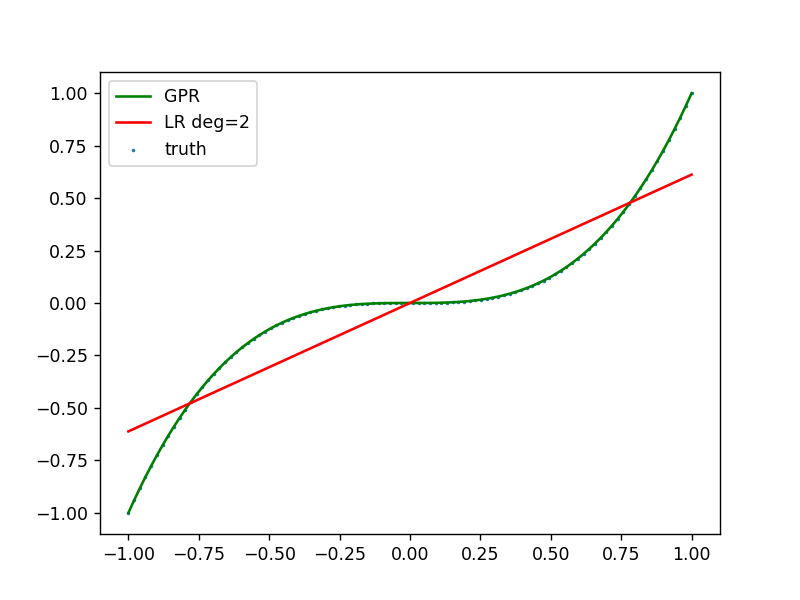

interactive(children=(FloatSlider(value=10.0, description='sigma', max=10.0), Output()), _dom_classes=('widget…

In [7]:
fig, ax = plt.subplots()

@wdg.interact(sigma=wdg.FloatSlider(min=0, max=10, value=10, step=0.1))
def plot_comparison(sigma):
    N = 100
    x = np.linspace(-1,1,N)
    #e = np.random.normal(0, 0.1, N)
    y = x**3
    # GPR
    #kernel = DotProduct(sigma_0=0, sigma_0_bounds='fixed')
    kernel = ConstantKernel(1.0, (1e-3, 1e10)) * RBF(100, (1e-3, 1e10))
    gp = GaussianProcessRegressor(kernel=kernel, alpha=sigma,  n_restarts_optimizer=10)
    gp.fit(np.atleast_2d(x).T, np.atleast_2d(y).T)
    y_pred_gpr, gp_sigma = gp.predict(np.atleast_2d(x).T, return_std=True)
    #LR
    d=2
    poly = PolynomialFeatures(degree=d)
    X_ = poly.fit_transform(np.atleast_2d(x).T)
    reg = LinearRegression()
    reg.fit(X_, np.atleast_2d(y).T)
    y_pred_cv_reg = reg.predict(poly.fit_transform(np.atleast_2d(x).T))
    ax.clear()
    ax.scatter(x, y, marker='o', s=1, label='truth')
    ax.plot(x, y_pred_gpr, label="GPR", color='g')
    ax.plot(x, y_pred_cv_reg, label="LR deg=2", color='r')
    ax.legend()    

# Appendix

## Multivariate Normal Distribution

**Definition (univariate normal)**: A real-valed random variable $X$ is *Gaussian* or *normal* if it has a density $p$ against the Lebesgue measure and there are $\mu, \sigma \in \mathbb{R}$, $\sigma >0$ such that
\begin{align*}
    \forall x \in \mathbb{R}: p(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\Big(-\frac{(x-\mu)^2}{2 \sigma^2}\Big)
\end{align*}
In this case, we write $X \sim \mathcal{N}(\mu, \sigma^2)$. We call $\mu$ the *mean* and $\sigma^2$ the *variance*. 
In case $\mathbb{P}[X=\mu]=1$, we also write $X \sim \mathcal{N}(\mu, 0)$.

**Definition (multivariate normal)**: An $\mathbb{R}^d$-valued random variable $X$ is *Gaussian* if there exists $\mu \in \mathbb{R}^d$ and a positive semi-definite $\Sigma \in \mathbb{R}^{d \times d}$ such that
\begin{align*}
    \forall v \in \mathbb{R}^d: v^{\intercal} X \sim \mathcal{N}(v^{\intercal} \mu, v^{\intercal} \Sigma v)
\end{align*}
In this case, we write $X \sim \mathcal{N}(\mu, \Sigma)$ and $\mu$ is called the *mean vector* and $\Sigma$ is called the *covariance matrix*.

Notice that this implies that the components $X_i \sim \mathcal{N}(\mu_i, \Sigma_{ii})$ and $\operatorname{Cov}[X_i, X_j] = \Sigma_{ij}$. Conversely, if $X_1, \ldots, X_d$ are independent and $X_i \sim \mathcal{N}(\mu_i, \sigma_i^2)$, then $X=(X_1, \ldots, X_d) \sim \mathcal{N}(\mu, \operatorname{diag}(\sigma_i^2))$ .

**Lemma (density)**: If $X$ is multivariate Gaussian and $\Sigma$ is positive definite, then $X$ has a density satisfying
\begin{align*}
    \forall x \in \mathbb{R}^d: p(x) = (2 \pi)^{-\tfrac{d}{2}} \det(\Sigma)^{-\tfrac{1}{2}} \exp(-\tfrac{1}{2}(x-\mu)^{\intercal} \Sigma^{-1}(x-\mu))
\end{align*}
The matrix $K := \Sigma^{-1}$ is called the *concentration* of the distribution.

**Lemma (linear transformations)**: Let $X \in \mathcal{N}(\mu, \Sigma)$ of dimension $d$ and $A \in \mathbb{R}^{r \times d}$ and $b \in \mathbb{R}^r$. Then $Y := AX + b \in \mathcal{N}(A \mu + b, A \Sigma A^{\intercal})$ of dimension $r$.

**Theorem (partition and condition):** Let $X=(X_1, X_2)$, where $X_i$ are $\mathbb{R}^{d_i}$-valued. If $X \sim \mathcal{N}(\mu, \Sigma)$ of dimension $d:=d_1 + d_2$, then $X_i \sim \mathcal{N}(\mu_i, \Sigma_{ii})$ of dimension $d_i$, where
\begin{align*}
    \mu = \begin{pmatrix}
        \mu_1 \\
        \mu_2
    \end{pmatrix}, 
    && \Sigma = \begin{pmatrix}
        \Sigma_{11} & \Sigma_{12} \\
        \Sigma_{21} & \Sigma_{22}
    \end{pmatrix}
    && K = \begin{pmatrix}
        K_{11} & K_{12} \\
        K_{21} & K_{22}
    \end{pmatrix}    
\end{align*}
with $\mu_i \in \mathbb{R}^{d_i}$, $\Sigma_{ii},K_{ii} \in \mathbb{R}^{d_i \times d_i}$, $i=1,2$. 

In case $\Sigma_{22}$ is regular, then 
\begin{align*}
    \forall x_2 \in \mathbb{R}^{d_2}: \mathbb{E}[X_1 \mid X_2=x_2] \sim \mathcal{N}(\mu_{1 \mid 2}, \Sigma_{1 \mid 2}),
\end{align*}
where
\begin{align*}
    \mu_{1 \mid 2} := \mu_1 + \Sigma_{12} \Sigma_{22}^{-1}(x_2 - \mu_2), && \Sigma_{1 \mid 2} .= \Sigma_{11} - \Sigma_{12} \Sigma_{22}^{-1} \Sigma_{21}
\end{align*}


## Matrix Inversion Lemma

**Lemma**: Let $Z \in \mathbb{R}^{n \times n}$, $W \in \mathbb{R}^{m \times m}$, $U,V \in \mathbb{R}^{n \times m}$. If $Z$, $W$ and $Z+UWV^{\top}$ are invertible, then
\begin{align*}
    (Z+ UWV^{\top})^{-1}
    &= Z^{-1} + Z^{-1} U (W^{-1} + V^{\top} Z^{-1} U) V^{\top} Z^{-1}
\end{align*}